# Identify spatial domains on mouse spleen from  Spatial Protein and Transcriptome Sequencing (SPOTS).


In this tutorial, we foucs on the SPOTS mouse spleen data. The raw data and processed data are available at [Google Drive](https://drive.google.com/drive/folders/1KdROJtA2Q774pXRjZTS4853ZhBD9NBZW?usp=sharing).

In [2]:


import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import os

import sys
sys.path.insert(0, '/lustre/project/Stat/s1155202250/fastfolder/code/st/MultiGATE/MultiGATEgithub0607/tutorial_notebooks')
import MultiGATE 



## Preparation

In [4]:

base_path = './output'


### Load RNA data

In [6]:


file_name= "../data_tutorial/spleen/spleen_RNA_processed_0308.h5ad" 
stage = os.path.basename(file_name).split('_')[0]
adata1 = sc.read_h5ad(file_name)
adata1


AnnData object with n_obs × n_vars = 2653 × 14371
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'
    obsm: 'spatial'

------Calculating spatial graph...
The graph contains 15482 edges, 2653 cells.
5.8357 neighbors per cell on average.


5.835657745947984

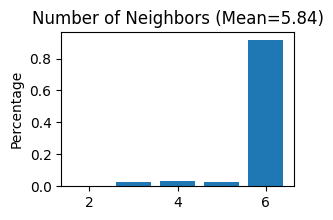

In [8]:

adata1.obsm["spatial"] = adata1.obsm["spatial"][:, [1, 0]]
adata1.obsm["spatial"][:, 1]= adata1.obsm["spatial"][:, 1]*(-1)
MultiGATE.Cal_Spatial_Net(adata1, rad_cutoff=40) 
MultiGATE.Stats_Spatial_Net(adata1)


### Load ATAC data

In [10]:

file_name= "../data_tutorial/spleen/spleen_Pro_processed_0308.h5ad"
adata2 = sc.read_h5ad(file_name)
adata2.obsm["spatial"] = adata2.obsm["spatial"][:, [1, 0]]
adata2.obsm["spatial"][:, 1]= adata2.obsm["spatial"][:, 1]*(-1)
adata2


AnnData object with n_obs × n_vars = 2653 × 21
    obsm: 'spatial'

------Calculating spatial graph...
The graph contains 15482 edges, 2653 cells.
5.8357 neighbors per cell on average.


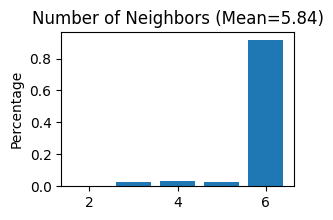

In [11]:

MultiGATE.Cal_Spatial_Net(adata2, rad_cutoff=40)
MultiGATE.Stats_Spatial_Net(adata2)

adata1 = adata1[:, adata1.var['highly_variable']]
# keep all ADTs in adata2, therefore we do not select highly variable features here.




### load the protein-gene net
The mouse spleen peak-gene net can be accessed at: [Google Drive](https://drive.google.com/drive/folders/1KdROJtA2Q774pXRjZTS4853ZhBD9NBZW?usp=sharing)

In [12]:
# 
peak_gene_net = pd.read_csv('/lustre/project/Stat/s1155202250/fastfolder/code/st/MultiGATE/Protein_gene/protein_gene_encode/enhanced_query_gene_connections.csv')
peak_gene_net=peak_gene_net[['Gene','QueryName']]
peak_gene_net.columns = ['Gene','Protein']
adata1 = adata1[:, adata1.var['highly_variable']]
# keep all ADTs in adata2, therefore we do not select highly variable features here.

# Check if peak names exist in adata2
valid_peaks = peak_gene_net['Protein'].isin(adata2.var_names)
peak_gene_net = peak_gene_net[valid_peaks]

# Check if gene names exist in adata1
valid_genes = peak_gene_net['Gene'].isin(adata1.var_names)
peak_gene_net = peak_gene_net[valid_genes]

MultiGATE.Cal_gene_protein_Net(adata1, adata2) 

adata1.uns['gene_peak_Net'] = peak_gene_net
adata2.uns['gene_peak_Net'] = peak_gene_net



------Calculating gene-protein graph...
------Calculation finished...


## Running MultiGATE

In [43]:

num_epoch = 3000 #1000  3000
adata1, adata2 = MultiGATE.train_MultiGATE(adata1, adata2,  type='protein', n_epochs=num_epoch,save_attention=True) 

2025-06-08 13:40:41.526826: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:3b:00.0
2025-06-08 13:40:41.526935: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2025-06-08 13:40:41.526953: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2025-06-08 13:40:41.526968: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2025-06-08 13:40:41.526982: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2025-06-08 13:40:41.526993: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10.0
2025-06-08 13:40:41.527006: I tensorflow/stream_executor

In [44]:
# the location of R (used for the mclust clustering)
os.environ['R_HOME'] = "/lustre/project/Stat/s1155077016/condaenvs/Seurat4/lib/R" 
os.environ['R_USER'] = '/users/s1155077016/anaconda3/lib/python3.9/site-packages/rpy2'

In [45]:
size=20
n_clusters=5
adata1 = MultiGATE.mclust_R(adata1, used_obsm='MultiGATE_clip_all', num_cluster=n_clusters)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


## Plotting the results

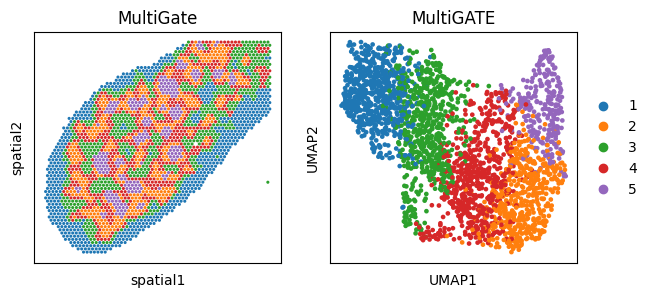

<Figure size 700x300 with 0 Axes>

In [52]:

plt.rcParams["figure.figsize"] = (7, 3) 
fig, axs = plt.subplots(1, 2)
sc.pl.embedding(adata1, basis='spatial', color='mclust',  title='MultiGate', s=size, show=False,ax=axs[0],legend_loc=None)
sc.pp.neighbors(adata1, use_rep='MultiGATE_clip_all',key_added = 'avg');
sc.tl.umap(adata1,neighbors_key = 'avg');
sc.pl.umap(adata1, color="mclust",title='MultiGATE',ax=axs[1]);

plt.tight_layout()
plt.show()